# Pregunta 1

# Generación y descripción de los datos

In [3]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
CHAS_0     506 non-null uint8
CHAS_1     506 non-null uint8
dtypes: float64(9), int64(4), uint8(2)
memory usage: 52.5 KB


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS_0,CHAS_1
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806,0.930830,0.069170
std,8.601545,23.310593,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104,0.253994,0.253994
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000,0.000000,0.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000,1.000000,0.000000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000,1.000000,0.000000
75%,3.677082,12.000000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000,1.000000,0.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000,1.000000


Los atributos del dataset corresponden a los siguientes:

1. **CRIM**:     Tasa de crimen per capita por cada poblado
2. **ZN**:         Proporción de terreno residencial construido para lotes de más de 25.000 pies cuadrados
3. **INDUS**:      Proporción de hectareas de negocios no-retail por cada poblado
4. **CHAS**:       Si el tramo limita al río Charles
5. **NOX**:        Concentración de óxido nítrico (pertes por 10 millones)
6. **RM**:         Habitaciones promedio por morador
7. **AGE**:        Proporción de viviendas ocupadas antes de 1940
8. **DIS**:        Distancia pesada a 5 centros de empleo en Boston
9. **RAD**:        Índice de accesibilidad a autopistas cercanas
10. **TAX**:       Tasa de propiedad completa (full-value property-tax rate per) 10,000
11. **PTRATIO**:   Razó profesor-alumno por poblado
12. **B**:         $1000 (B_k - 0.63)^2$ donde $B_k$ es la proporción de gente de color por poblado
13. **LSTAT**:     porcentaje de la población con bajo estatus (Se asume económico)
14. **MEDV**:      Valor real de la vivienda

Referencia: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').reshape(-1,1)

X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = df_test.pop('MEDV').reshape(-1,1)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


#### Boxplot

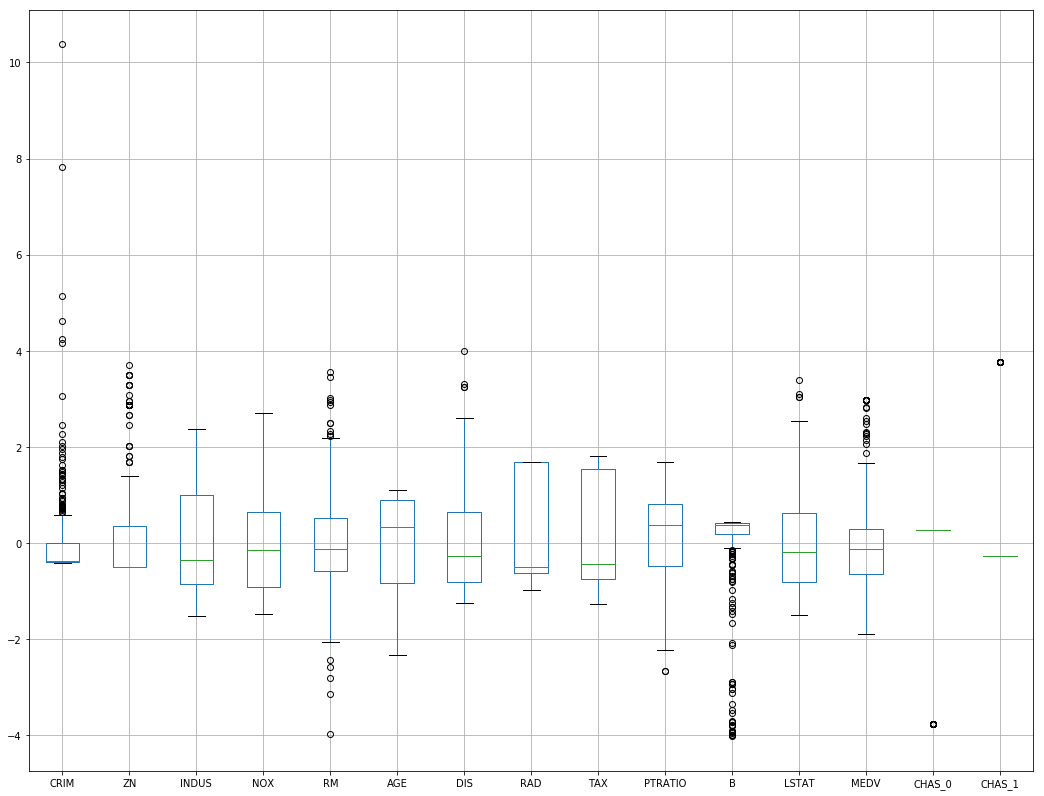

In [5]:
import matplotlib.pyplot as plt
X_train_scaled.boxplot(figsize=(18, 14))
plt.show()

#### Distribuciones

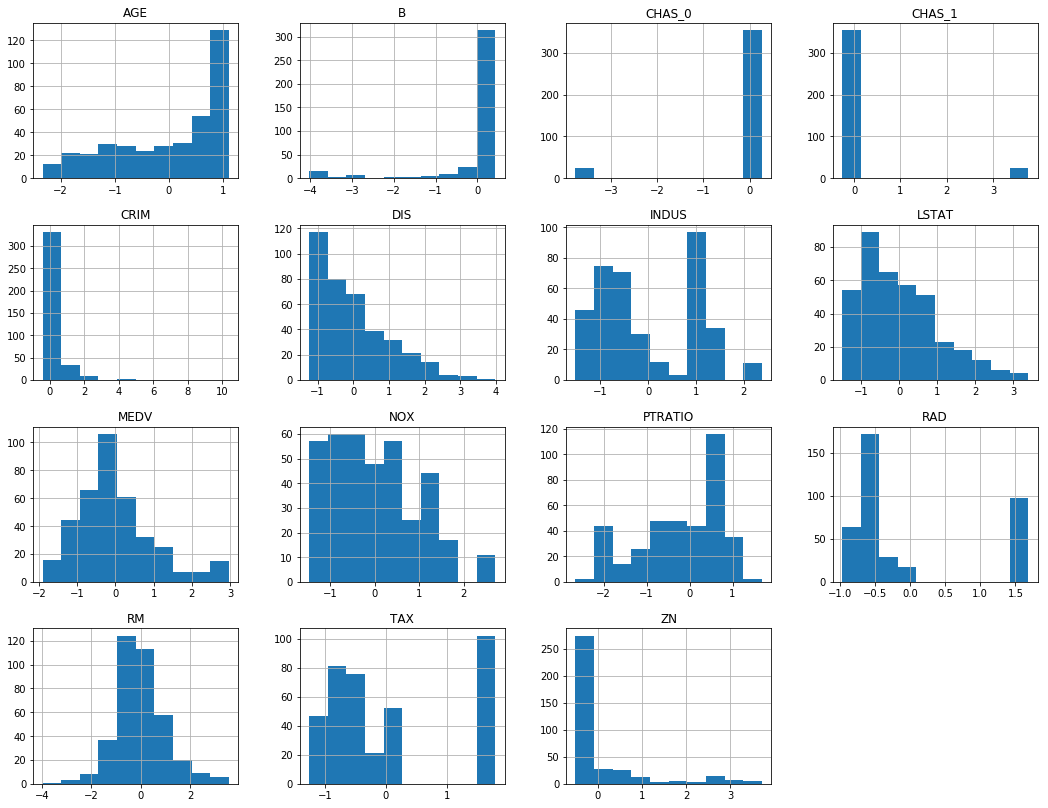

In [6]:
import matplotlib.pyplot as plt
X_train_scaled.hist(figsize=(18, 14))
plt.show()

#### Relación Feature-Feature

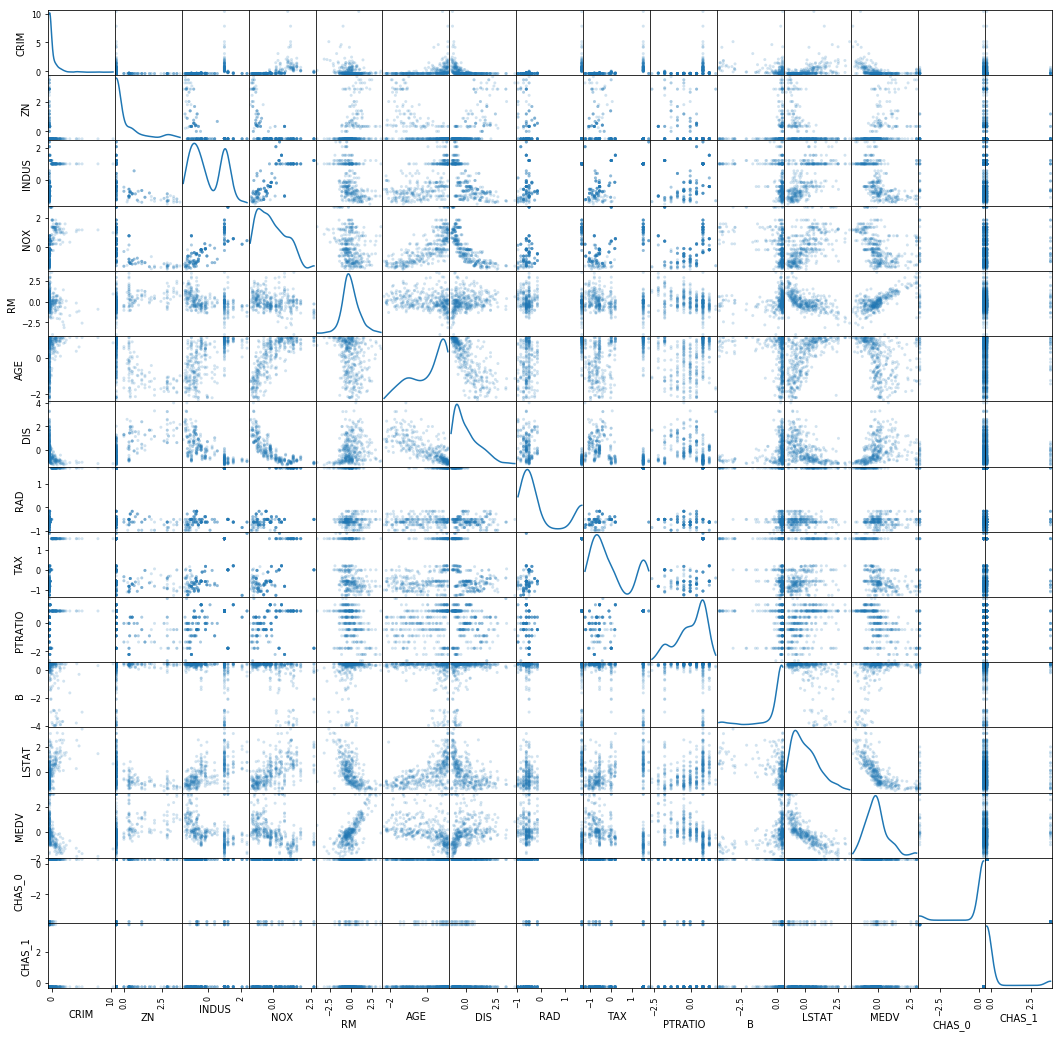

In [7]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(X_train_scaled, alpha=0.2, figsize=(18, 18), diagonal='kde')
plt.show()

# Entrenamiento de la red

A continuación se definen métodos para simplificar los experimentos posteriores:

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD


def compile_network(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
    
def fit_network(model, epochs=300):
    hist = model.fit(X_train_scaled, y_train, epochs=epochs,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
    return hist


### Entrenamiento de red neuronal con sigmoid (Pregunta B)

In [11]:
import random
random.seed(30)
model = compile_network()
hist = fit_network(model)

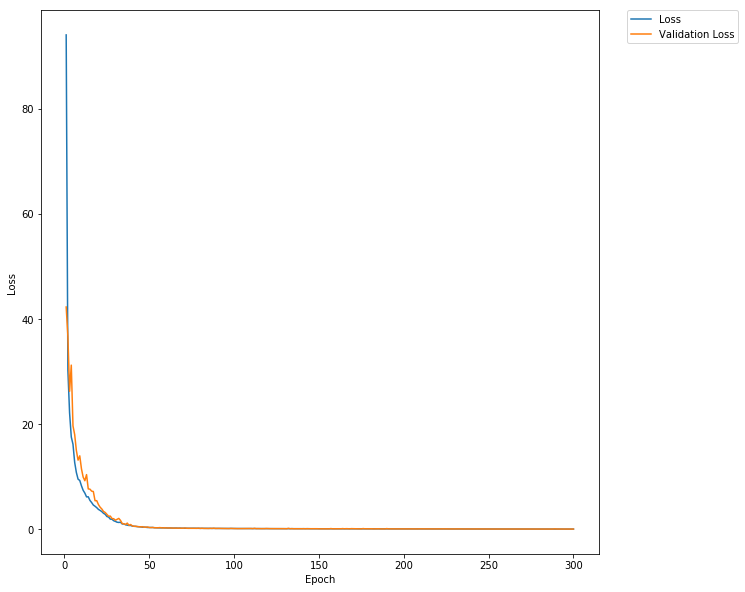

In [12]:
import matplotlib.pyplot as plt
loss_y = hist.history['loss']
loss_x = range(1, 301)

val_loss_y = hist.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, loss_y, label="Loss")
plt.plot(loss_x, val_loss_y, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

Para observar la convergencia dados distintas ejecuciones del experimento, se corre este 20 veces utilizando distintos seeds específicos

In [13]:
import numpy as np
import random

seeds = np.linspace(20, 400, 20)

results = []

for seed in seeds:
    random.seed(seed)
    model = compile_network()
    hist = fit_network(model)
    results.append(hist)

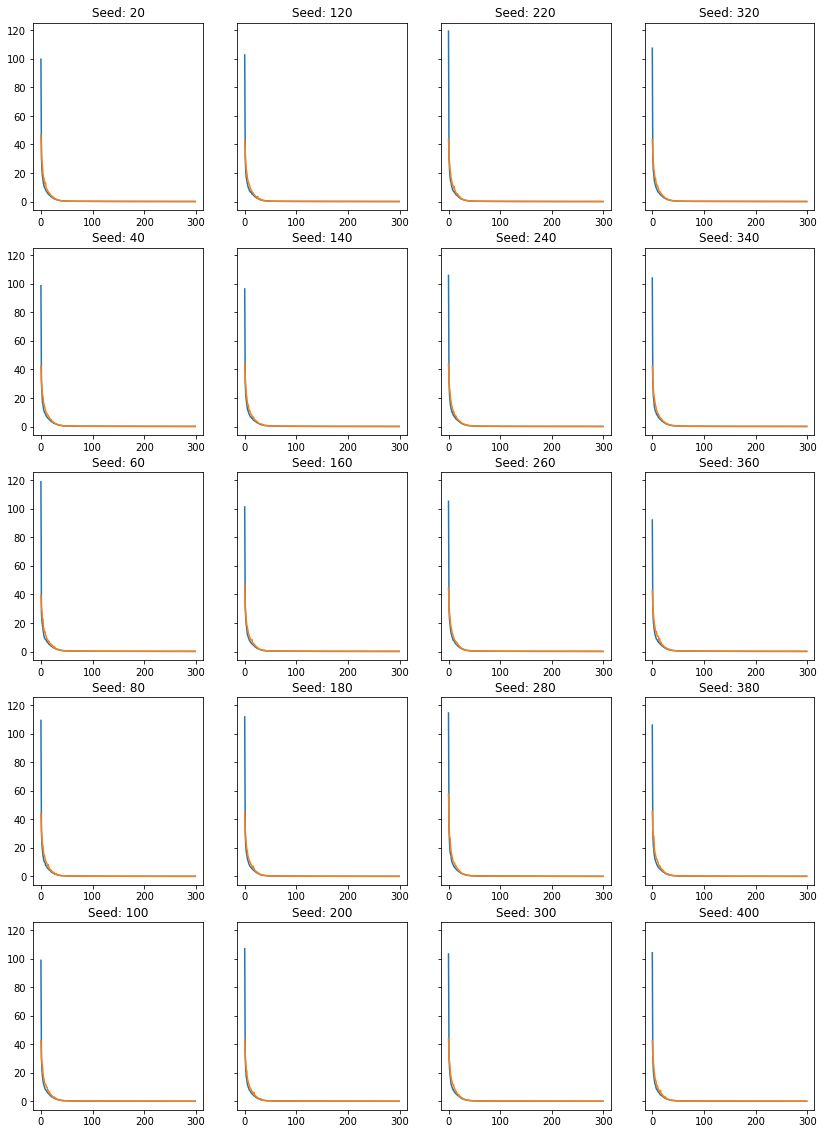

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), sharey=True)

counter = 0
for seed in seeds:
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("Seed: %d" % (seed))
    counter += 1
plt.show()



### Entrenamiento de red neuronal con ReLU (Pregunta C)

In [15]:
import numpy as np
import random

seeds = np.linspace(20, 400, 20)

results = []

for seed in seeds:
    random.seed(seed)
    model = compile_network(hidden_activation="relu")
    hist = fit_network(model)
    results.append(hist)

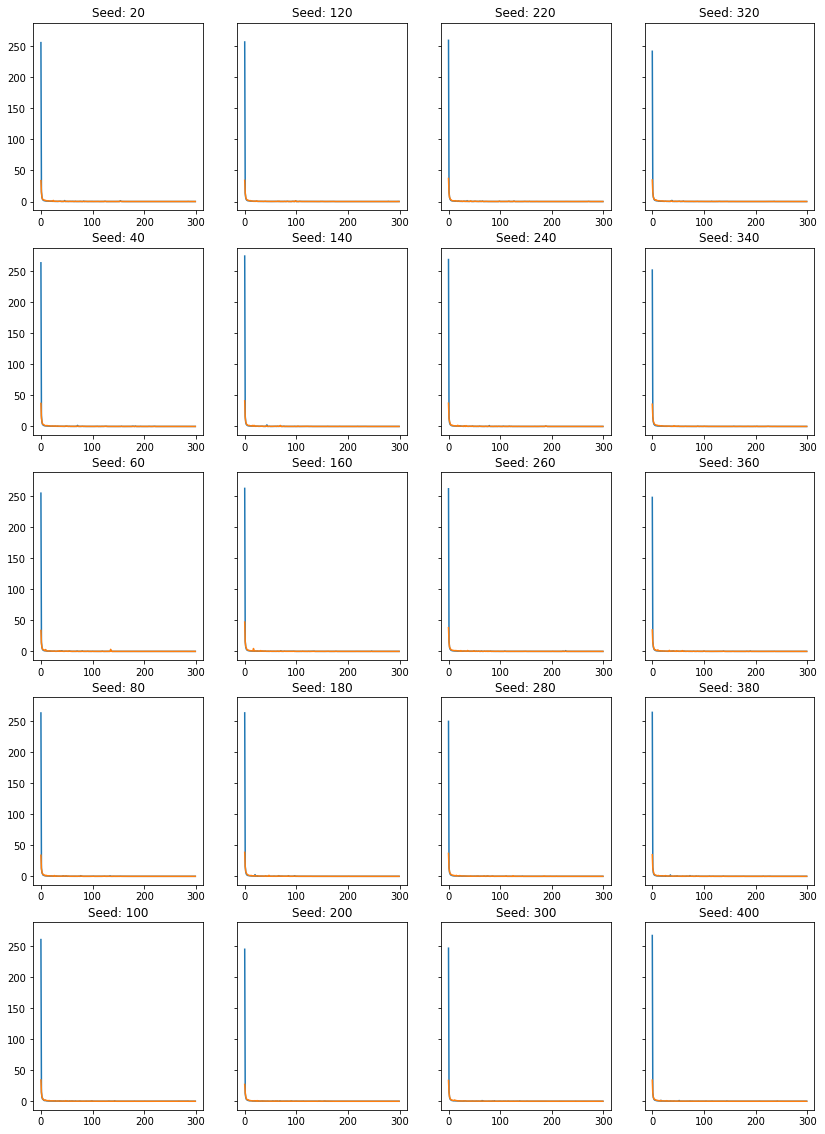

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), sharey=True)

counter = 0
for seed in seeds:
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("Seed: %d" % (seed))
    counter += 1
plt.show()


### Efecto del learning rate
A continuación se evalúa el efecto del learning rate

##### Sigmoid

In [21]:
import numpy as np
n_lr = 20
learn_rates = np.linspace(0,1,n_lr)

results = []

for lr in learn_rates:
    random.seed(30)
    model = compile_network(lr=lr)
    hist = fit_network(model)
    results.append(hist)

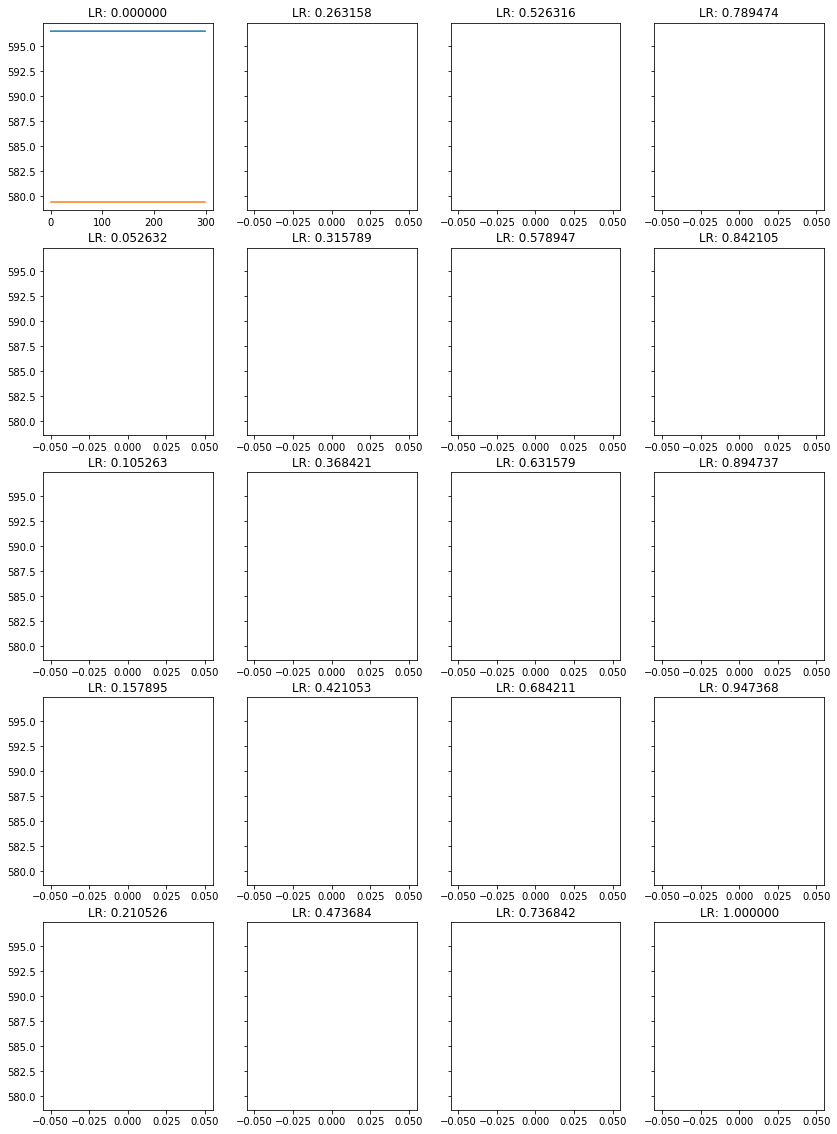

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), sharey=True)

counter = 0
for lr in learn_rates:
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("LR: %f" % (lr))
    counter += 1
plt.show()

##### ReLU

In [19]:
import numpy as np
n_lr = 20
learn_rates = np.linspace(0,1,n_lr)

results = []

for lr in learn_rates:
    random.seed(30)
    model = compile_network(lr=lr, hidden_activation="relu")
    hist = fit_network(model)
    results.append(hist)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), sharey=True)

counter = 0
for lr in learn_rates:
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["loss"], label="Loss")
    axes[counter % 5, counter // 5].plot(range(0, len(results[counter].history["loss"])), results[counter].history["val_loss"], label="Val Loss")
    axes[counter % 5, counter // 5].set_title("LR: %d" % (lr))
    counter += 1
plt.show()

### Efecto de progressive decay

 Compare y comente.

### Efecto de batches

Experimente con diferentes tamaños del batch. Comente.

### Comparación de estrategias modernas

¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de pruebas?

### Comparación de regularización

Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa vs la segunda, comente.

### Efecto de dropout

Experimente con distintos valores del parámetro de regularización y comente.

### Cross validation

¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.